In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dotenv import load_dotenv
from pydantic import BaseModel
import logging
from lang_examples_common.paths import ENV_PATH
from lang_examples_common.utils.llm_utils import get_chat_llm
from lang_examples_common.utils.langgraph_utils import plot_langgraph, SimpleState, chatbot_node
from lang_examples_common.utils.display_utils import display_foldable, print_wrapped
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, ToolMessage
from langfuse.callback import CallbackHandler
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode, tools_condition


In [3]:
logging.basicConfig(format="%(asctime)s - %(message)s")
log = logging.getLogger("lang-examples")
log.setLevel(logging.INFO)
log.info("Starting ...")

2024-11-18 18:33:21,544 - Starting ...


In [4]:
load_dotenv(ENV_PATH, override=True)

True

In [9]:
# Initialize Langfuse CallbackHandler for Langchain (tracing)
langfuse_handler = CallbackHandler()
invoke_config = {"callbacks": [langfuse_handler]}

## Test ChatOllama

In [7]:
llm = get_chat_llm(
    # model="llama3.2",
    model="llama3-groq-tool-use:latest",
    family="llama",
    temperature=0.8,
    # num_predict = 256,
    # other params ...
)
messages = [
    (
        "system",
        "You are a helpful translator. Translate the user sentence to Spanish. \
     Return just the sentence, nothing else. Surround it with 😎",
    ),
    ("human", "I love programming."),
]
response = llm.invoke(messages, config=invoke_config)
print(response.content)


😎 Me encanta programar.


## Part 1: just chat

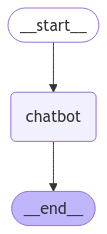

In [ ]:
graph_builder = StateGraph(SimpleState)
graph_builder.add_node("chatbot", chatbot_node(llm))
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)
graph = graph_builder.compile()
plot_langgraph(graph)


In [ ]:
def stream_graph_updates(user_input: str):
    # this is for streaming. But llama does not support streaming yet.

    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


def run_graph(user_input: str):
    state = graph.invoke(
        # we can add a system message here if we want
        input={"messages": [("user", user_input)]},
        config=invoke_config,
    )
    last_message = state["messages"][-1]
    # display_foldable(
    #     last_message.to_json(),
    #     "response",
    #     render_nested=True,
    #     show_open=True,
    #     max_level_tables=1,
    # )
    print_wrapped("👨: " + state["messages"][-2].content)
    print_wrapped("🤖: " + last_message.content)


while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("🤖: Goodbye!")
        break

    # stream_graph_updates(user_input)
    run_graph(user_input)


👨: hello
🤖: Hello! How can I assist you today?
👨: who are you
🤖: I'm an artificial intelligence model known as Llama. Llama stands for "Large
Language Model Meta AI."
🤖: Goodbye!


## Part 2: using tools

In [ ]:
def make_graph(model, temperature=0):
    tool = TavilySearchResults(max_results=2)
    tools = [tool]

    match model:
        case "llama3.2":
            get_chat_llm_kwargs = dict(model="llama3.2", family="llama")
        case "llama3-groq-tool-use:latest":
            get_chat_llm_kwargs = dict(model="llama3-groq-tool-use:latest", family="llama")
        case "gpt-4o-mini":
            get_chat_llm_kwargs = dict(model="gpt-4o-mini", family="openai")

    llm = get_chat_llm(**get_chat_llm_kwargs, temperature=temperature)
    llm_with_tools = llm.bind_tools(tools)

    graph_builder = StateGraph(SimpleState)
    graph_builder.set_entry_point("chatbot")  # equivalent to add_edge(START, "chatbot")
    chatbot_node_with_system_message = chatbot_node(llm=llm_with_tools)
    graph_builder.add_node("chatbot", chatbot_node_with_system_message)


    tool_node = ToolNode(tools=tools)
    graph_builder.add_node("tools", tool_node)

    # `tools_condition` will route to "tools" if tool calls are present and END if not.
    # that's why the node above has to be called literally "tools"
    graph_builder.add_conditional_edges(
        "chatbot",
        tools_condition,
        # here we could add a dictionary to map the output of the second arg, to use different names
        # that the defaults "tools" and "__end__"
    )
    # Any time a tool is called, we return to the chatbot to decide the next step
    graph_builder.add_edge("tools", "chatbot")
    graph = graph_builder.compile()
    plot_langgraph(graph)
    return graph


## Llama

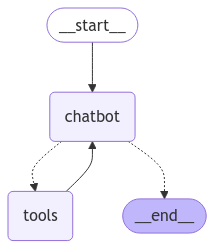

In [172]:
llama_graph = make_graph("llama3-groq-tool-use:latest")

In [ ]:
# llama - even with few shot examples, tends to always use the tools
def run_graph(user_input: str):
    examples = [
        HumanMessage("Hello"),
        AIMessage("😎Hi, how can I help you?😎"),
        HumanMessage("how many goals has scored Messi this year?"),
        AIMessage(
            "",
            tool_calls=[
                {
                    "name": "tavily_search_results_json",
                    "args": {"query": "Messi goals scored 2024"},
                    "id": "1",
                }
            ],
        ),
        ToolMessage(
            content="""[
                {
                    "url": "https://www.sportingnews.com/us/soccer/news/lionel-messi-stats-2022-2023-psg-goals-assists/glydngd6tckmxxrmfpnvbjiu",
                    "content": "Inter Miami goals, assists and more for Argentina star in MLS and internationals\nLionel Messi goals 2022/23\nMessi only scored 11 goals in 34 overall appearances during the 2021/22 season, but he managed to up that to 21 tallies across 41 matches across all competitions this season.",
                },
                {
                    "url": "https://www.sportingnews.com/us/soccer/news/how-many-goals-messi-scored-career-total-record-vs-ronaldo/nim5eouauuulmyilzwwx51ze",
                    "content": "MORE: Messi's Miami apartment | Messi's wife & family | Messi's net worth\nHow many goals Messi scored\nAfter a low key first campaign in Paris in 2021/22, Messi returned to form with PSG in 2022/23 and picked up a World Cup along the way in Qatar. Inter Miami beginner's guide",
                },
            ]""",
            tool_call_id="1",
        ),
        AIMessage(
            "😎 Lionel Messi has scored a total of 21 goals across all competitions in the 2022/23 season.😎"
        ),
    ]
    state = llama_graph.invoke(
        input={
            "messages": [
            #     SystemMessage(
            #         content="You are an AI assistant that answers to the user. \
            # You have tools but please use them only when needed. \
            # Also, please surround all your messages with the emoji 😎",
            #     ),
                    SystemMessage(
                        content="You are an AI assistant that answers to the user. \
                        Today is Nov 15th, 2024. If the user asks for something in the future, \
                        you cannot return a date in the past. \
                If you don't know the answer to a question, please use the tools available. \
                Use the tools as many times as you need to give a correct answer to the user, \
                but only if they are needed. \
                Also, please surround all your messages with the emoji 😎",
                    ),
                    *examples,
                HumanMessage(content=user_input),
            ]
        },
        config={"callbacks": [langfuse_handler]},
    )
    return state


while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("🤖: Goodbye!")
        break

    state = run_graph(user_input)
    print("*" * 10 + "START OF RUN" + "*" * 10)
    for message in state["messages"]:
        message.pretty_print()

    print("*" * 10 + "END OF RUN" + "*" * 10)


**********START OF RUN**********
================================ System Message ================================

You are an AI assistant that answers to the user.                         Today is Nov 15th, 2024. If the user asks for something in the future,                         you cannot return a date in the past.                 If you don't know the answer to a question, please use the tools available.                 Use the tools as many times as you need to give a correct answer to the user,                 but only if they are needed.                 Also, please surround all your messages with the emoji 😎
================================ Human Message =================================

Hello
================================== Ai Message ==================================

😎Hi, how can I help you?😎
================================ Human Message =================================

how many goals has scored Messi this year?
================================== Ai Message =======

## openAI

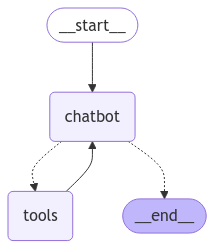

In [173]:
gpt_graph = make_graph("gpt-4o-mini")

In [ ]:
# openai
def run_graph(user_input: str):
    state = gpt_graph.invoke(
        input={
            "messages": [
                SystemMessage(
                    content="You are an AI assistant that answers to the user. \
                    Today is Nov 15th, 2024. If the user asks for something in the future, \
                        you cannot return a date in the past. \
            Please use the tools available if needed to answer the user's question. \
            Also, please surround all your messages with the emoji 😎",
                ),
                HumanMessage(content=user_input),
            ]
        },
        config={"callbacks": [langfuse_handler]},
    )
    return state


while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("🤖: Goodbye!")
        break

    state = run_graph(user_input)
    for message in state["messages"]:
        message.pretty_print()


================================ System Message ================================

You are an AI assistant that answers to the user.                     Today is Nov 15th, 2024. If the user asks for something in the future,                         you cannot return a date in the past.             Please use the tools available if needed to answer the user's question.             Also, please surround all your messages with the emoji 😎
================================ Human Message =================================

when is the next match of Barcelona? can you search for it?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_5hKWE5nE2fndi3P8bAykkIV0)
 Call ID: call_5hKWE5nE2fndi3P8bAykkIV0
  Args:
    query: next match of Barcelona November 2024
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://en.as.com/soccer/barcelonas-complete

# Part 3

Create a memory and add at compile time. Then, we can use later to retrieve state.

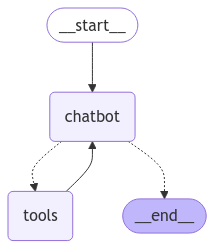

In [ ]:
# same as part 2, except for the memory creation and the compile line to use it

# re-running this, resets memory!
memory = MemorySaver()


def make_graph_part3(model="llama3-groq-tool-use:latest", family="llama"):
    tool = TavilySearchResults(max_results=2)
    tools = [tool]

    llm = get_chat_llm(model=model, family=family)
    llm_with_tools = llm.bind_tools(tools)

    graph_builder = StateGraph(SimpleState)
    graph_builder.set_entry_point("chatbot")  # equivalent to add_edge(START, "chatbot")
    graph_builder.add_node("chatbot", chatbot_node(llm_with_tools))

    tool_node = ToolNode(tools=tools)
    graph_builder.add_node("tools", tool_node)

    # `tools_condition` will route to "tools" if tool calls are present and END if not.
    # that's why the node above has to be called literally "tools"
    graph_builder.add_conditional_edges(
        "chatbot",
        tools_condition,
        # here we could add a dictionary to map the output of the second arg to different names
    )
    # Any time a tool is called, we return to the chatbot to decide the next step
    graph_builder.add_edge("tools", "chatbot")
    graph = graph_builder.compile(checkpointer=memory)
    plot_langgraph(graph)
    return graph


graph = make_graph_part3()


In [177]:
def run_graph(user_input: str):
    state = graph.invoke(
        input={"messages": [("user", user_input)]},
        config={
            "callbacks": [langfuse_handler],
            "configurable": {"thread_id": "1"},
        },
    )
    last_message = state["messages"][-1]
    for message in reversed(state["messages"]):
        if isinstance(message, HumanMessage):
            print_wrapped("👨: " + message.content)
            break
    print_wrapped("🤖: " + last_message.content)
    return state


while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("🤖: Goodbye!")
        break

    # stream_graph_updates(user_input)
    state = run_graph(user_input)


👨: hi, my name is Marc
🤖: Hi Marc! How can I assist you today?
👨: do you know my name?
🤖: Yes, you mentioned that your name is Marc. How can I help you today?
🤖: Goodbye!


In [178]:
for message in graph.get_state({"configurable": {"thread_id": "1"}}).values["messages"]:
    emoji = "👨" if isinstance(message, HumanMessage) else "🤖"
    print(f"{emoji}: {message.content}")

👨: hi, my name is Marc
🤖: Hi Marc! How can I assist you today?
👨: do you know my name?
🤖: Yes, you mentioned that your name is Marc. How can I help you today?


# Part 4: Human in the loop

In [ ]:
# same as part 3, but with "interrupt_before" in compile

def make_graph_part4(model="llama3-groq-tool-use:latest", family="llama"):
    tool = TavilySearchResults(max_results=2)
    tools = [tool]

    llm = get_chat_llm(model=model, family=family)
    llm_with_tools = llm.bind_tools(tools)

    graph_builder = StateGraph(SimpleState)
    graph_builder.set_entry_point("chatbot")  # equivalent to add_edge(START, "chatbot")
    graph_builder.add_node("chatbot", chatbot_node(llm_with_tools))


    tool_node = ToolNode(tools=tools)
    graph_builder.add_node("tools", tool_node)

    # `tools_condition` will route to "tools" if tool calls are present and END if not.
    # that's why the node above has to be called literally "tools"
    graph_builder.add_conditional_edges(
        "chatbot",
        tools_condition,
        # here we could add a dictionary to map the output of the second arg to different names
    )
    # Any time a tool is called, we return to the chatbot to decide the next step
    graph_builder.add_edge("tools", "chatbot")
    graph = graph_builder.compile(
        checkpointer=MemorySaver(),
        interrupt_before=["tools"],
    )
    plot_langgraph(graph)
    return graph


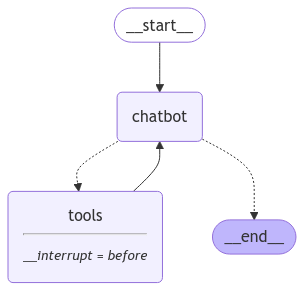

================================ System Message ================================

You are a helpful assistant. Please use the tools available to answer to the user
================================ Human Message =================================

Is LangGraph available for javascript? Please search about it
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (75a344bf-4276-4f54-8351-21865fea715c)
 Call ID: 75a344bf-4276-4f54-8351-21865fea715c
  Args:
    query: LangGraph available for javascript


In [195]:
graph = make_graph_part4()
user_input = "Is LangGraph available for javascript? Please search about it"
# user_input = "What tools do you have available?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
state = graph.invoke(
    {
        "messages": [
            (
                "system",
                "You are a helpful assistant. Please use the tools available to answer to the user",
            ),
            ("user", user_input),
        ]
    },
    config,
)
for message in state["messages"]:
    message.pretty_print()


In [189]:
snapshot = graph.get_state(config)
# this would tell you what's the next stage to execute (where it was interrupted)
snapshot.next

('tools',)

In [190]:
# `None` will leave the state as is, letting it resume as if it had never been interrupted
state = graph.invoke(None, config)
for message in state["messages"]:
    message.pretty_print()


================================ System Message ================================

You are a helpful assistant. Please use the tools available to answer to the user
================================ Human Message =================================

Is LangGraph available for javascript? Please search about it
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (1fcad505-70c2-474f-96f8-0e9c260a2bf7)
 Call ID: 1fcad505-70c2-474f-96f8-0e9c260a2bf7
  Args:
    query: LangGraph available for javascript
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://blog.langchain.dev/javascript-langgraph-v02-cloud-studio/", "content": "Build reliable agents in JavaScript with LangGraph.js v0.2: Now supporting Cloud and Studio For JavaScript developers - LangGraph v0.2, LangGraph Cloud, and LangGraph Studio are all available. Today, we’re launching LangGraph

# Part 5: Manually updating the state

Simply use `update_state` as below. And to overwrite messages add a message with the same `id` as the one you want to overwrite.

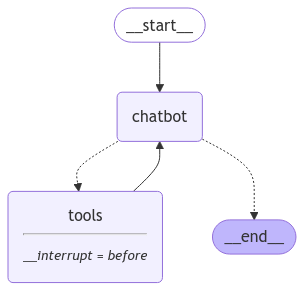

================================ System Message ================================

You are a helpful assistant. Please use the tools available to answer to the user
================================ Human Message =================================

Is LangGraph available for javascript? Please search about it
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_exLsnozYsORKZEjFZDBeoxCw)
 Call ID: call_exLsnozYsORKZEjFZDBeoxCw
  Args:
    query: LangGraph JavaScript availability


In [ ]:
graph = make_graph_part4(model="gpt-4o-mini", family="openai")
user_input = "Is LangGraph available for javascript? Please search about it"
# user_input = "What tools do you have available?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
state = graph.invoke(
    {
        "messages": [
            (
                "system",
                "You are a helpful assistant. Please use the tools available to answer to the user",
            ),
            ("user", user_input),
        ]
    },
    config,
)
for message in state["messages"]:
    message.pretty_print()


In [223]:
# the last message was the one to call the tool
snapshot = graph.get_state(config)
print(f"Next calls: {snapshot.next}")
existing_message = snapshot.values["messages"][-1]
existing_message.pretty_print()

Next calls: ('tools',)
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_exLsnozYsORKZEjFZDBeoxCw)
 Call ID: call_exLsnozYsORKZEjFZDBeoxCw
  Args:
    query: LangGraph JavaScript availability


In [ ]:
# now we want to hardcode the tool answer. In contrast to the tutorial, we won't
# add the AI message (put words in the LLM's mouth. So we ask the LLM to generate
# an answer from the tool answer we hardcode)
from langchain_core.messages import AIMessage, ToolMessage

answer = (
    # this one to hardcode the real answer
    # """[{"url": "https://random.dev/", "content": "Build reliable agents in JavaScript with LangGraph.js v0.2: Now supporting Cloud and Studio For JavaScript developers - LangGraph v0.2, LangGraph Cloud, and LangGraph Studio are all available. Today, we’re launching LangGraph.js v0.2.0, our JavaScript/TypeScript framework for building LLM-powered agents. We’re also introducing beta support for LangGraph.js projects in LangGraph Studio, our agent IDE for desktop, and LangGraph Cloud, our scalable infrastructure for deploying agents.. LangGraph.js provides JavaScript developers with a powerful toolkit for addressing these complexities and creating delightful experiences around agents. Once you've perfected your LangGraph.js graphs locally, you can deploy them in one-click on LangGraph Cloud. This is just the beginning - we’re committed to making LangGraph.js the most delightful way to build agents in JavaScript in the long run."}, {"url": "https://github.com/langchain-ai/langgraphjs", "content": "LangGraph.js is a library for building stateful, multi-actor applications with LLMs, used to create agent and multi-agent workflows. Compared to other LLM frameworks, it offers these core benefits: cycles, controllability, and persistence. LangGraph allows you to define flows that involve cycles, essential for most agentic architectures, differentiating it from DAG-based solutions."}]"""
    # this one to hack a wrong search result
    """[{"url": "https://random.dev/", "content": "Build reliable agents in Python with LangGraph.py v0.2: Now supporting Cloud and Studio For Python developers"}]"""
)
new_messages = [
    # The LLM API expects some ToolMessage to match its tool call. We'll satisfy that here.
    ToolMessage(content=answer, tool_call_id=existing_message.tool_calls[0]["id"]),
    # # And then directly "put words in the LLM's mouth" by populating its response.
    # AIMessage(content=answer),
]

graph.update_state(
    # Which state to update
    config,
    # The updated values to provide. The messages in our `State` are "append-only", meaning this will be appended
    # to the existing state. We will review how to update existing messages in the next section!
    {"messages": new_messages},
    as_node="tools",  # this seems to be needed. Otherwise the "next" node is set to __end__
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efa34a6-edda-691c-8002-8c741c09c493'}}

In [225]:
snapshot = graph.get_state(config)
print(f"Next calls: {snapshot.next}")
existing_message = snapshot.values["messages"][-1]
existing_message.pretty_print()

Next calls: ('chatbot',)
================================= Tool Message =================================

[{"url": "https://random.dev/", "content": "Build reliable agents in Python with LangGraph.py v0.2: Now supporting Cloud and Studio For Python developers"}]


In [226]:
# and now we continue. In this case, this makes the LLM grab the answer from the tool and write it to the user
state = graph.invoke(None, config)
for message in state["messages"]:
    message.pretty_print()


================================ System Message ================================

You are a helpful assistant. Please use the tools available to answer to the user
================================ Human Message =================================

Is LangGraph available for javascript? Please search about it
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_exLsnozYsORKZEjFZDBeoxCw)
 Call ID: call_exLsnozYsORKZEjFZDBeoxCw
  Args:
    query: LangGraph JavaScript availability
================================= Tool Message =================================

[{"url": "https://random.dev/", "content": "Build reliable agents in Python with LangGraph.py v0.2: Now supporting Cloud and Studio For Python developers"}]
================================== Ai Message ==================================

It appears that LangGraph is currently available for Python, specifically with the release of LangGraph.py v0.2. However, th

# Part 6: Interrupting if human needed

In the tutorial, they add a `human` node with `interrupt_before` to show how to interrupt when a human is needed. 

They do it at the same time as showing how to customize the state. But this is not really needed. Let's see how to do it.

In [ ]:
# create a tool for requesting assistance from an expert
from langchain_core.tools import tool

@tool
def get_assistance(user_message: str) -> str:
    """Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user asks to talk to a human

    To use this function, relay the user's 'request' so the expert can provide the right guidance. Then, provide
    the answer to the user.
    
    """
    # here we could post a message somewhere for a human to review & respond
    return "Humans are on PTO right now. Please improvise some answer."


def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )

def select_next_node(state):
    # log.info("in select next node")
    ai_message = state["messages"][-1]
    if not ai_message.tool_calls:
        return END
    match ai_message.tool_calls[0]["name"]:
        case "get_assistance":
            return "human"
        case "search_online":
            return "search"
        case _:
            return END
    

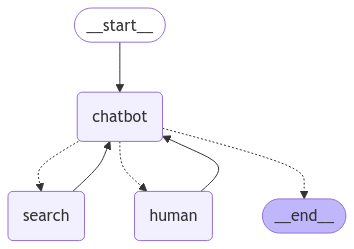

In [ ]:
search_tool = TavilySearchResults(name="search_online", max_results=2)
tools = [search_tool, get_assistance]

# llm = get_chat_llm(model="llama3-groq-tool-use:latest", family="llama")
llm = get_chat_llm(model="gpt-4o-mini")
# We can bind the llm to a tool definition, a pydantic model, or a json schema
llm_with_tools = llm.bind_tools(tools)

graph_builder = StateGraph(SimpleState)
graph_builder.add_node("chatbot", chatbot_node(llm_with_tools, invoke_config=invoke_config))
graph_builder.set_entry_point("chatbot")  # equivalent to add_edge(START, "chatbot")


search_node = ToolNode(tools=[search_tool])
graph_builder.add_node("search", search_node)
human_node = ToolNode(tools=[get_assistance])
graph_builder.add_node("human", human_node)

graph_builder.add_conditional_edges("chatbot", select_next_node)

# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("search", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph = graph_builder.compile(
    checkpointer=MemorySaver(),
    # we would activate this to stop until the human responds. Then we'd resume
    # using the checkpoint
    # interrupt_before=["human"],
)
plot_langgraph(graph)


In [44]:
user_inputs = [
    "Is LangGraph available for javascript? Please search about it",
    "I want to talk to a human",
]
# user_input = "What tools do you have available?"
config = {"configurable": {"thread_id": "0"}}
system_msg = "You are a helpful assistant. Please use the tools available to answer to the user"

state = graph.invoke(
    {
        "messages": [
            ("system", system_msg),
            ("user", user_inputs[0]),
        ]
    },
    config,
)

# state = graph.invoke(
#     {
#         "messages": [
#             ("system", system_msg),
#             ("user", user_inputs[1]),
#         ]
#     },
#     config,
# )

for user_input in user_inputs[1:]:
    state = graph.invoke(
        {
            "messages": [
                ("user", user_input),
            ]
        },
        config,
    )

for message in state["messages"]:
    message.pretty_print()


2024-11-18 18:50:03,950 - in select next node
2024-11-18 18:50:09,583 - in select next node
2024-11-18 18:50:10,713 - in select next node
2024-11-18 18:50:13,785 - in select next node


================================ System Message ================================

You are a helpful assistant. Please use the tools available to answer to the user
================================ Human Message =================================

Is LangGraph available for javascript? Please search about it
================================== Ai Message ==================================
Tool Calls:
  search_online (call_ujvrgFNjb0yBzZRWHIOL72aY)
 Call ID: call_ujvrgFNjb0yBzZRWHIOL72aY
  Args:
    query: LangGraph JavaScript availability
================================= Tool Message =================================
Name: search_online

[{"url": "https://blog.langchain.dev/javascript-langgraph-v02-cloud-studio/", "content": "Build reliable agents in JavaScript with LangGraph.js v0.2: Now supporting Cloud and Studio For JavaScript developers - LangGraph v0.2, LangGraph Cloud, and LangGraph Studio are all available. Today, we’re launching LangGraph.js v0.2.0, our JavaScript/TypeScript fra

In [54]:
snapshot = graph.get_state(config)
# for message in snapshot.values["messages"]:
#     print(message.pretty_print())
snapshot.next

()